# Analysis Code for _On believing and hoping whether_

[Aaron Steven White](http://aaronstevenwhite.io)<br/> 
_University of Rochester_<br/>
`aaron.white@rochester.edu`<br/>
_Last Updated:_ 4 Jan 2021

This notebook contains all of the analyses from: 

> White, A.S. 2021. [On believing and hoping whether](https://ling.auf.net/lingbuzz/005665/current.pdf). Accepted with revisions to _Semantics & Pragmatics_.

If you use any of the code found in this directory, please cite that
paper as well as [this repository](https://github.com/MegaAttitude/on-believing-and-hoping-whether.git).

## Notebook Contents

Code relevant to each of the following sections can be jumped to using the links below.

- [Section 3](#Experimental-evidence-against-the-generalizations)
- [Section 5](#Grammatical-correlates-of-polar-interrogative-taking)

These links will not work when viewing this notebook on github.

## Environment Setup

It is strongly recommended that you run this notebook using the docker image it is shipped with. See the README shipped with this notebook for details. The relevant Dockerfile is duplicated below.

```
FROM jupyter/datascience-notebook:cfddc5a3163f

LABEL maintainer.name="Aaron Steven White" \
      maintainer.email="aaron.white@rochester.edu" \
      maintainer.website="http://aaronstevenwhite.io" \
      project.name="MegaAttitude" \
      project.website="http://megaattitude.io" \
      subproject.name="MegaVeridicality, MegaNegRaising" \
      image.website="https://github.com/MegaAttitude/on-believing-and-hoping-whether" \
      image.version="1.1" \
      image.modification_date="2021-01-08"

COPY --chown=1000:100 ./*.ipynb /home/jovyan/work/

VOLUME /home/jovyan/work/

RUN mkdir data && mkdir plots

RUN pip install tensorflow==1.4.1

RUN R -e "install.packages(c('tidyverse', 'lme4'), repos='http://cran.us.r-project.org')"
```

Failure to use this docker image could result in minor differences in statistics from the published paper or inability to run the code at all due to API changes.

In [1]:
from typing import Tuple

import numpy as np
import pandas as pd
import tensorflow as tf

import rpy2
%load_ext rpy2.ipython

All plots will be written to a `plots/` directory within the container. We'll create that now (if it doesn't already exist).

In [2]:
%%bash

if [ ! -d "plots" ]
then
mkdir plots
else
echo "Directory ./plots already exists."
fi

Directory ./plots already exists.


# Experimental evidence against the generalizations

Section 3 presents a replication of White and Rawlins' (2018) analysis of the relationship between veridicality and responsivity using the [MegaAcceptability](http://megaattitude.io/projects/mega-acceptability/) and [MegaVeridicality](http://megaattitude.io/projects/mega-veridicality/) datasets as well as a novel analysis of the relationship between neg-raising and responsivity using [MegaAcceptability](http://megaattitude.io/projects/mega-acceptability/) and [MegaNegRaising](http://megaattitude.io/projects/mega-negraising/). You can jump to the code for each analysis using the links below.

- [Veridicality and responsivity](#Experimental-evidence-against-Egre's-generalization)
- [Neg-raising and responsivity](#Experimental-evidence-against-Zuber's-and-Theiler-et-al.'s-generalization)

These links will not work when viewing this notebook on github.

## Experimental evidence against Egre's generalization

Section 3.1 begins with a simulation based on the predictions of Egre's (2008) generalization. This simulation assumes that veridical responsives are distributed $\mathcal{N}\left([1, 1], \begin{bmatrix}\sigma^2 & 0\\0 & \sigma^2\end{bmatrix}\right)$ and that non-veridical antirogatives are distributed $\mathcal{N}\left([-1, -1], \begin{bmatrix}\sigma^2 & 0\\0 & \sigma^2\end{bmatrix}\right)$ on the veridicality and responsivity dimensions, respectively. 

The variance $\sigma^2$ is specified in these simulations via a parameter `distance_std_ratio` $ = \frac{\text{dist}([1, 1], [-1, -1])}{\sigma} = \frac{\sqrt{8}}{\sigma}$ (assuming the distance is Euclidean). Thus, $\sigma^2 = \frac{\sqrt{8}}{\text{ distance_std_ratio}^2}$.

In [3]:
def sample_egre_lexicon(npredicates: int=500, proportion_veridical: float=0.5, 
                        distance_std_ratio: float=10) -> Tuple[pd.DataFrame, float]:
    """Sample lexicon consistent with Egre's (2008) generalization
    
    Parameters
    ----------
    npredicates
        The number of predicates in the sampled lexicon
    proportion_veridical
        The proportion of predicates in the lexicon that should be veridical
    distance_std_ratio
        The ratio of the distance between the centroids of the classes and the standard deviation
        
    Returns
    -------
    data
        The simulated data
    corr
        The correlation between veridicality and responsivity in the simulated data
    """
    # compute variance from distance_std_ratio
    std = np.sqrt(8)/distance_std_ratio
    variance = np.square(std)
    
    # sample veridical responsives
    veridical_responsives = np.random.multivariate_normal(np.ones(2), 
                                                          variance*np.eye(2), 
                                                          size=int(npredicates*proportion_veridical))
    
    veridical_responsives = pd.DataFrame(veridical_responsives, 
                                         columns=['veridicality', 'responsivity'])
    
    veridical_responsives['class'] = 'veridical responsives'
    
    # sample nonveridical antirogatives
    nonveridical_antirogatives = np.random.multivariate_normal(-np.ones(2), 
                                                               variance*np.eye(2), 
                                                               size=int(npredicates*(1.-proportion_veridical)))
    
    nonveridical_antirogatives = pd.DataFrame(nonveridical_antirogatives, 
                                              columns=['veridicality', 'responsivity'])
    
    nonveridical_antirogatives['class'] = 'nonveridical antirogatives'
    
    # concatenate classes
    data = pd.concat([veridical_responsives, nonveridical_antirogatives]).reset_index(drop=True)
    
    # compute d'
    classes = np.array(['veridical responsives', 'nonveridical antirogatives'])
    means = np.array([np.ones(2), -np.ones(2)]).T # dimension x class
    
    predicates = data[['veridicality', 'responsivity']].values
    
    distances = np.sqrt(np.sum(np.square(predicates[:,:,None] - means[None,:,:]), axis=1))
    
    corr = np.corrcoef(data.veridicality, data.responsivity)[1, 0]
    
    return data, corr

The following simulates the data showing in Figure 1 (left).

In [4]:
np.random.seed(403928)

egre_lexicon, egre_corr = sample_egre_lexicon()

print('Correlation:', egre_corr)

egre_lexicon

Correlation: 0.927923438499


,veridicality,responsivity,class
0,0.908390,1.177066,veridical responsives
1,1.719512,1.232834,veridical responsives
2,1.129831,0.951906,veridical responsives
3,0.935622,1.048282,veridical responsives
4,1.013992,1.540834,veridical responsives
5,0.953602,0.637219,veridical responsives
6,0.870834,0.907289,veridical responsives
7,1.056069,0.683635,veridical responsives
8,1.039229,0.870632,veridical responsives
9,0.818639,0.882681,veridical responsives


/opt/conda/lib/python3.5/site-packages/rpy2/rinterface/__init__.py:186: RRuntimeWarning: Loading tidyverse: ggplot2
Loading tidyverse: tibble
Loading tidyverse: tidyr
Loading tidyverse: readr
Loading tidyverse: purrr
Loading tidyverse: dplyr

  warnings.warn(x, RRuntimeWarning)
/opt/conda/lib/python3.5/site-packages/rpy2/rinterface/__init__.py:186: RRuntimeWarning: Conflicts with tidy packages ---------------------------------------------------

  warnings.warn(x, RRuntimeWarning)
/opt/conda/lib/python3.5/site-packages/rpy2/rinterface/__init__.py:186: RRuntimeWarning: filter(): dplyr, stats
lag():    dplyr, stats

  warnings.warn(x, RRuntimeWarning)
/opt/conda/lib/python3.5/site-packages/rpy2/rinterface/__init__.py:186: RRuntimeWarning: `geom_smooth()` using formula 'y ~ x'

  warnings.warn(x, RRuntimeWarning)


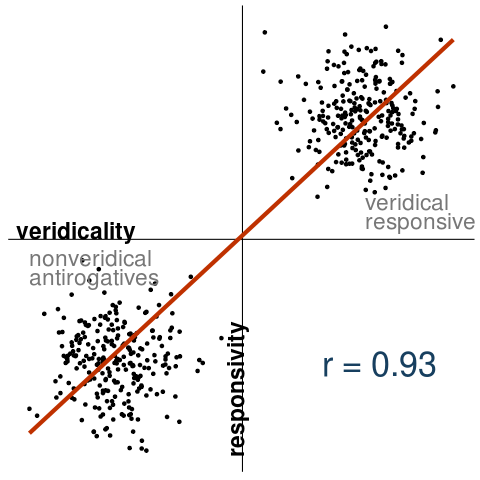

In [5]:
%%R -i egre_lexicon

library(tidyverse)

g = ggplot(egre_lexicon, aes(x=veridicality, y=responsivity)) + geom_point() + 
  geom_hline(yintercept=0) + geom_vline(xintercept=0) + 
  geom_smooth(se=F, method="lm", size=2, color="#BF3100") + 
  theme_classic() + 
  theme(axis.text=element_blank(), axis.title = element_blank(), axis.ticks = element_blank(), axis.line = element_blank()) + 
  annotate("text", x=min(egre_lexicon$veridicality)+.38, y=.075, label="veridicality", size=8, fontface="bold") + 
  annotate("text", x=-.06, y=min(egre_lexicon$responsivity)+.5, label="responsivity", size=8, fontface="bold", angle=90) + 
  annotate("text", x=min(egre_lexicon$veridicality), y=-.15, label="nonveridical", color="#777777", size=8, hjust=0) + 
  annotate("text", x=min(egre_lexicon$veridicality), y=-.3, label="antirogatives", color="#777777", size=8, hjust=0) +
  annotate("text", x=1, y=.3, label="veridical", color="#777777", size=8, hjust=0) + 
  annotate("text", x=1, y=.15, label="responsives", color="#777777", size=8, hjust=0) + 
  annotate("text", x=.65, y=-1, label=paste("r =", round(cor(egre_lexicon$veridicality, egre_lexicon$responsivity), 2)), color="#173f5f", size=12, hjust=0)

ggsave('plots/egre-predictions.pdf', width=8, height=8)

g

The following simulates the data shown in Figure 2 (left).

In [6]:
np.random.seed(403928)

distance_std_ratios = [2**k for k in range(-5, 5)]
veridical_proportions = [i/10 for i in range(1, 10, 2)]

egre_stats = []

for r in distance_std_ratios:
    for p in veridical_proportions:
        mean_ci = np.percentile([sample_egre_lexicon(proportion_veridical=p, 
                                                     distance_std_ratio=r)[1] 
                                 for _ in range(999)], 
                                [2.5, 50, 97.5])
        egre_stats.append([p, r] + list(mean_ci))
        
egre_stats = pd.DataFrame(egre_stats, 
                          columns=['proportion_veridical', 
                                   'distance_std_ratio', 
                                   'cilo', 'med', 'cihi'])

egre_stats

,proportion_veridical,distance_std_ratio,cilo,med,cihi
0,0.1,0.03125,-0.089793,0.000991,0.084552
1,0.3,0.03125,-0.092442,-0.002288,0.087411
2,0.5,0.03125,-0.090083,0.000952,0.091275
3,0.7,0.03125,-0.085708,-0.001885,0.090651
4,0.9,0.03125,-0.084681,-0.001939,0.086876
5,0.1,0.06250,-0.093474,0.000981,0.090109
6,0.3,0.06250,-0.085941,-0.000172,0.085250
7,0.5,0.06250,-0.089353,-0.001137,0.085574
8,0.7,0.06250,-0.091161,-0.002508,0.090424
9,0.9,0.06250,-0.083074,0.000633,0.082918


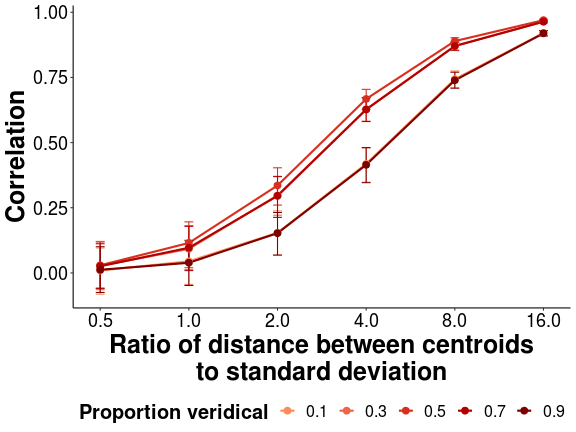

In [7]:
%%R -i egre_stats -w 8 -h 6 -u in

library(tidyverse)

g = ggplot(filter(egre_stats, distance_std_ratio>=0.5), 
       aes(x=distance_std_ratio, y=med, ymin=cilo, ymax=cihi, color=as.factor(proportion_veridical))) +
scale_x_continuous(trans='log2', breaks=c(0.5, 1, 2, 4, 8, 16)) +
geom_line(size=1) +
geom_errorbar(width=0.1) +
geom_point(size=3) +
scale_color_manual(name="Proportion veridical", values=c('#fc8d59','#ef6548','#d7301f','#b30000','#7f0000')) +
xlab("Ratio of distance between centroids\nto standard deviation") +
ylab('Correlation') +
theme_classic() +
theme(legend.position="bottom",
     axis.text=element_text(size=18, color="black"),
     axis.title=element_text(size=25, face="bold"),
     legend.text=element_text(size=16, color="black"),
     legend.title=element_text(size=20, face="bold"))

ggsave('plots/egre-simulations.pdf', width=8, height=6)

g

With the simulations complete, we now turn to actual data. We first compute White & Rawlins' (2018) measure of interrogative-taking, declarative-taking, and responsivity from the normalized version of the MegaAcceptability dataset.

In [8]:
acceptability_url = 'http://megaattitude.io/projects/mega-acceptability/mega-acceptability-v1/mega-acceptability-v1-normalized.tsv'

acceptability = pd.read_csv(acceptability_url, sep='\t')

acceptability.head()

,verb,verbform,frame,sentence,responsenorm,responsevar
0,abhor,abhorred,NP Ved,Someone abhorred .,0.937020,-2.288458
1,abhor,abhorred,NP Ved NP,Someone abhorred something .,1.757018,-1.554375
2,abhor,abhorred,NP Ved NP VP,Someone abhorred someone do something .,-1.728826,-1.018119
3,abhor,abhorred,NP Ved NP VPing,Someone abhorred someone doing something .,1.018668,-1.245996
4,abhor,abhorred,NP Ved NP that S,Someone abhorred someone that something happen...,-0.595499,-0.585704


In [9]:
acceptability_finite = acceptability[acceptability.frame.isin(['NP Ved that S', 'NP Ved S',
                                                               'NP was Ved that S', 'NP was Ved S',
                                                               'NP Ved whether S', 'NP Ved whichNP S',
                                                               'NP was Ved whether S', 'NP was Ved whichNP S'])]

acceptability_finite['interrogative'] = acceptability_finite.frame.isin(['NP Ved whether S', 
                                                                         'NP Ved whichNP S',
                                                                         'NP was Ved whether S', 
                                                                         'NP was Ved whichNP S'])
acceptability_finite['direct_object'] = acceptability_finite.frame.isin(['NP was Ved that S', 
                                                                         'NP was Ved S',
                                                                         'NP was Ved whether S', 
                                                                         'NP was Ved whichNP S'])

acceptability_finite_max = acceptability_finite.pivot_table(index=['verb', 'interrogative', 'direct_object'], 
                                                            values='responsenorm',
                                                            aggfunc=np.max).reset_index()

acceptability_finite_max

/opt/conda/lib/python3.5/site-packages/ipykernel_launcher.py:9: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/indexing.html#indexing-view-versus-copy
  if __name__ == '__main__':
/opt/conda/lib/python3.5/site-packages/ipykernel_launcher.py:13: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/indexing.html#indexing-view-versus-copy
  del sys.path[0]


,verb,interrogative,direct_object,responsenorm
0,abhor,False,False,1.130769
1,abhor,False,True,1.159245
2,abhor,True,False,0.752146
3,abhor,True,True,0.362723
4,absolve,False,False,0.193910
5,absolve,False,True,0.183086
6,absolve,True,False,-0.270916
7,absolve,True,True,0.214287
8,accept,False,False,1.799351
9,accept,False,True,-0.612224


In [10]:
responsivity = acceptability_finite_max.pivot_table(index=['verb', 'direct_object'],
                                                    columns='interrogative').reset_index()

responsivity = responsivity.rename(columns={True: 'interrogativity', False: 'declarativity'})

responsivity.columns = [' '.join(col).strip().replace('responsenorm ', '')
                        for col in responsivity.columns.values]

responsivity['responsivity'] = responsivity[['interrogativity', 'declarativity']].min(axis=1)

responsivity.sort_values('responsivity', ascending=False)

,verb,direct_object,declarativity,interrogativity,responsivity
640,doubt,False,3.892889,3.441625,3.441625
1004,imply,False,4.126986,3.399402,3.399402
2004,write,False,3.378750,3.325572,3.325572
994,imagine,False,3.243869,3.298039,3.243869
480,deduce,False,3.236445,3.315744,3.236445
376,confirm,False,3.513769,3.231746,3.231746
1242,note,False,3.257437,3.188991,3.188991
1466,recall,False,3.314133,3.051914,3.051914
1198,miss,False,3.002100,3.388115,3.002100
1538,report,False,3.176715,2.968006,2.968006


We then compute a normalized veridicality score for all of the verbs in MegaVeridicality.

In [11]:
veridicality_url = 'http://megaattitude.io/projects/mega-veridicality/mega-veridicality-v1/mega-veridicality-v1.csv'

veridicality = pd.read_csv(veridicality_url)

veridicality = veridicality.query('~conditional & nativeenglish & ~exclude')
veridicality = veridicality[~veridicality.veridicality.isnull()]

veridicality['direct_object'] = veridicality.voice.map({'active': False, 'passive': True})

veridicality.head()

,participant,list,presentationorder,verb,frame,voice,polarity,conditional,veridicality,acceptability,nativeenglish,exclude,direct_object
0,219,0,1,surmise,that_S,active,positive,False,maybe,6,True,False,False
1,219,0,2,update,that_S,active,positive,False,yes,2,True,False,False
2,219,0,3,disregard,that_S,active,negative,False,maybe,4,True,False,False
3,219,0,4,agree,that_S,active,positive,False,yes,4,True,False,False
4,219,0,5,surmise,that_S,active,negative,False,maybe,3,True,False,False


In [12]:
veridicality['item'] = veridicality.polarity + '-' + veridicality.verb + '-' +\
                       veridicality.frame + '-' + veridicality.voice

This normalization uses exactly the ordinal mixed model based normalizer used by White & Rawlins (2020) to generate normalized acceptability judgments.

In [13]:
def fit_ordinal_normalizer(response: pd.Series, obj: pd.Series, participant: pd.Series, 
                           weights: pd.Series = None, smoothing: float = 1., 
                           iterations: int = 25000, verbose: int = 1000, 
                           seed: int = 204938) -> Tuple[np.array, np.array, np.array, np.array]:
    """Fit an ordinal normalizer
    
    Parameters
    ----------
    response
        The ordinal responses
    obj
        The objects the ordinal responses were assigned to
    participant
        The participant that provided each ordinal response
    weights
        The weight to assign to each response
    smoothing
        The pseudocount of responses below and above the midpoint to smooth with
    iterations
        The number of iterations to run the normalizer
    verbose
        The interval between iterations
    seed
        The random seed
        
    Returns
    -------
    normed_obj
        The normalized values
    likes_all
        The likelihood of the ordinal response
    jumps
        The distances between cutpoints for each participant
    cuts_shifted
        The cutpoints for each participant
    """
    # the total number of responses
    n = response.shape[0]
    
    # convert the input data to tf constants
    resp_tf = tf.constant(np.array(list(zip(np.arange(n), 
                                            response.astype(np.int32)))))
    obj_tf = tf.constant(obj.astype(np.int32))
    part_tf = tf.constant(participant.astype(np.int32))
    
    # the number of responds, participants, and objects
    nresp = np.unique(response).shape[0]
    npart = np.unique(participant).shape[0]
    nobj = np.unique(obj).shape[0]
    
    # initialize the normalized values
    normed = tf.Variable(tf.random_normal([nobj], 
                                          0, 1e-5, 
                                          seed=seed))
    normed_obj = tf.gather(normed, obj_tf)
    
    # initialize the distances between cutpoints for each participant
    jumps_aux = tf.Variable(tf.random_normal([npart, nresp-1], 
                                             0, 1e-5, 
                                             seed=seed+1))
    jumps = tf.square(jumps_aux)
    
    # find the middle of the ordinal scale
    mid = np.floor(nresp/2).astype(int)
    
    # compute the cutpoints from the distances between them
    cuts = tf.cumsum(jumps, axis=1)
    cuts_mean = tf.reduce_mean(cuts, axis=0)
    cuts_shifted = cuts - cuts_mean[mid]
    cuts_part = tf.gather(cuts_shifted, part_tf)
    
    # compute the log probabilities for each response
    prob_leq = tf.sigmoid(cuts_part-normed_obj[:,None])
    
    prob_leq_high = tf.concat([prob_leq, tf.ones([n, 1])], axis=1)
    prob_leq_low = tf.concat([tf.zeros([n, 1]), prob_leq], axis=1)
    
    probs = tf.gather_nd(prob_leq_high, resp_tf) - tf.gather_nd(prob_leq_low, resp_tf)
    
    # compute the prior log probability (random effects loss)
    jumps_norm = jumps/tf.reduce_mean(jumps, axis=0)[None,:]
    prior = tf.reduce_sum(jumps_norm)
    
    # weight the likelihood by the weights if provided
    if weights is not None:  
        weights_tf = tf.constant(weights.astype(np.float32))
        
        likes_all = weights_tf*tf.log(probs+1e-10)
        like = -tf.reduce_sum(likes_all)
    else:
        likes_all = tf.log(probs+1e-10)
        like = -tf.reduce_sum(likes_all)
    
    # apply the smoothing if non-zero
    if smoothing:
        cuts_mean = tf.reduce_mean(cuts_shifted, axis=0)
        prob_leq_mean = tf.sigmoid(cuts_mean[mid]-normed)
        like_smoothed = like -\
                        tf.reduce_sum(smoothing*tf.log(prob_leq_mean)+\
                                      smoothing*tf.log(1-prob_leq_mean))
    
        loss = like_smoothed+prior
    else:
        loss = like+prior
    
    # initialize the optimizer
    optimizer = tf.train.AdamOptimizer(0.1)

    train_op = optimizer.minimize(loss)

    sess.run(tf.global_variables_initializer())
    
    grads_and_vars = optimizer.compute_gradients(loss)
    
    # run the optimization
    for i in range(iterations):
        _, lk, pr, l, p = sess.run([train_op, like, prior, loss, probs])
        if not i % verbose:
            print('iteration:', ' '*9, i)
            print('likelihood:', ' '*8, np.round(lk, 3))
            print('prior:', ' '*13, np.round(pr, 3)) 
            print('loss:', ' '*14, np.round(l, 3))
            print('mean probability:', ' '*2, np.round(p.mean(), 3))
            print()
            
    return normed_obj.eval(), likes_all.eval(), jumps.eval(), cuts_shifted.eval()

In [14]:
veridicality_response_codes = veridicality.veridicality.astype('category', 
                                                               categories=['no', 'maybe', 'yes']).cat.codes
veridicality_item_codes = veridicality.item.astype('category').cat.codes
veridicality_participant_codes = veridicality.participant.astype('category').cat.codes

with tf.Session() as sess:
    vernorm, verlike, verjumps, vercuts = fit_ordinal_normalizer(veridicality_response_codes,
                                                                 veridicality_item_codes,
                                                                 veridicality_participant_codes)
    
veridicality['veridicality_normalized'], veridicality['veridicality_like'] = vernorm, verlike

iteration:           0
likelihood:          103458.0
prior:               318.0
loss:                105284.0
mean probability:    0.301

iteration:           1000
likelihood:          9837.12
prior:               318.0
loss:                11996.8
mean probability:    0.525

iteration:           2000
likelihood:          7878.73
prior:               318.0
loss:                10051.5
mean probability:    0.567

iteration:           3000
likelihood:          6691.66
prior:               318.0
loss:                8895.63
mean probability:    0.603

iteration:           4000
likelihood:          6007.27
prior:               318.0
loss:                8252.04
mean probability:    0.632

iteration:           5000
likelihood:          5646.24
prior:               318.0
loss:                7931.38
mean probability:    0.653

iteration:           6000
likelihood:          5478.56
prior:               318.0
loss:                7794.46
mean probability:    0.664

iteration:           7000
li

Having finished normalization, we then merge the normalized acceptabilities with the normalized veridicalities. We ensure that we are looking at veridicality (rather than factivity), by filtering down to only the positive polarity items. Finally, we compute the correlation.

In [15]:
veridicality_positive = veridicality.query('polarity == "positive"')

veridicality_responsivity = pd.merge(veridicality_positive.pivot_table(index=['verb', 'direct_object'],
                                                                       values='veridicality_normalized').reset_index(),
                                     responsivity,
                                     on=['verb', 'direct_object'])

veridicality_responsivity

,verb,direct_object,veridicality_normalized,declarativity,interrogativity,responsivity
0,accept,False,1.182379,1.799351,1.564368,1.564368
1,acknowledge,False,1.289016,3.595051,2.116735,2.116735
2,add,False,0.485243,2.903775,1.677302,1.677302
3,address,False,1.091126,1.165668,2.428402,1.165668
4,admit,False,1.745062,2.648245,1.750189,1.750189
5,advertise,False,0.104927,2.669675,1.118480,1.118480
6,advise,False,0.428003,1.559931,1.264549,1.264549
7,advise,True,2.006868,2.021786,1.593163,1.593163
8,affirm,False,0.946202,2.119755,1.360767,1.360767
9,aggravate,True,1.745062,2.956551,0.813529,0.813529


/opt/conda/lib/python3.5/site-packages/rpy2/rinterface/__init__.py:186: RRuntimeWarning: `geom_smooth()` using formula 'y ~ x'

  warnings.warn(x, RRuntimeWarning)


[1] "r =  -0.1, 95% CI = [-0.2, 0]"


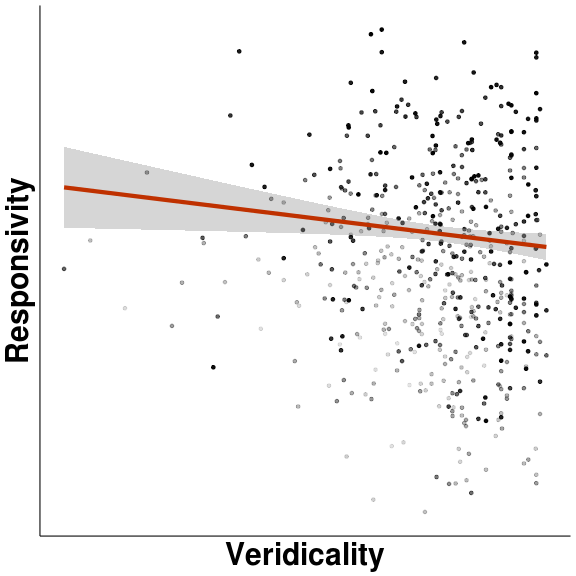

In [16]:
%%R -i veridicality_responsivity -w 8 -h 8 -u in

library(boot)
library(tidyverse)

theme_set(theme_classic())

zscore = function(x) (x - mean(x))/sqrt(var(x))

veridicality_responsivity$declarativity_weight = pnorm(zscore(veridicality_responsivity$declarativity), 0, 1)
    
compute.weighted.correlation = function(d, i){
    d2 <- d[i,]
    weighted_corr <- cov.wt(d2[c('veridicality_normalized', 'responsivity')], 
                            wt = d2$declarativity_weight, cor = TRUE)
    weighted_corr$cor['veridicality_normalized', 'responsivity']
}

  
set.seed(626)
bootcorr <- boot(veridicality_responsivity, compute.weighted.correlation, R=999)
r.ci = boot.ci(boot.out = bootcorr, type = c("norm"))$normal

verbs.to.label = c('know', 'figure_out', 'point_out', 'think', 'wonder', 'hope', 'fear', 'wish', 'imagine', 'dream', 
                   'tell', 'say', 'worry', 'panic', 'flip_out', 'decide', 'apologize', 'forgive', 
                   'repress', 'hush_up', 'prove', 'show', 'cry', 'notify', 'recognize',
                   'amaze', 'surprise', 'doubt', 'agree', 'lie', 'fake', 'misinform', 'pretend')

print(paste('r = ', paste0(round(bootcorr$t0, 2), ','),
            paste0('95% CI = [', 
                   round(r.ci[1,2], 2), ', ',
                   round(r.ci[1,3], 2), ']')))
    
p <- ggplot(veridicality_responsivity, aes(x=veridicality_normalized, y=responsivity, alpha=declarativity_weight)) +
geom_point() +
xlab('Veridicality') + ylab('Responsivity') +
geom_smooth(method="lm", mapping = aes(weight = declarativity_weight), color="#BF3100", size=2) +
theme(axis.text=element_blank(), axis.ticks=element_blank(), 
      axis.title = element_text(size=30, face="bold"), legend.position="none") #+
# annotate(geom="text", x=0, y=-1.5,  size=10, color="#173f5f",
#          label=paste('r = ', paste0(round(bootcorr$t0, 2), ','), 
#                      paste0('95% CI = [', 
#                             round(r.ci[1,2], 2), ', ',
#                             round(r.ci[1,3], 2), ']')))
    
ggsave('plots/veridicality-responsivity.pdf', width=8, height=8)
    
p

## Experimental evidence against Zuber's and Theiler et al.'s generalization

Section 3.2 begins with a simulation based on the predictions of Zuber's (1983) and Theiler et al.'s (2019) generalization. Similar to the simulation in Section 3.1, this simulation assumes that non-neg-raising responsives are distributed $\mathcal{N}\left([-1, 1], \begin{bmatrix}\sigma^2 & 0\\0 & \sigma^2\end{bmatrix}\right)$, that non-neg-raising antirogatives are distributed $\mathcal{N}\left([-1, -1], \begin{bmatrix}\sigma^2 & 0\\0 & \sigma^2\end{bmatrix}\right)$, and that neg-raising antirogatives are distributed $\mathcal{N}\left([1, -1], \begin{bmatrix}\sigma^2 & 0\\0 & \sigma^2\end{bmatrix}\right)$ on the neg-raising and responsivity dimensions, respectively.

The variance $\sigma^2$ is specified similarly to the simulations in Section 3.1, but in these simulations, we must specify which two categories we compute the distance between. To make everything as comparable to the simulations in Section 3.1, we use the distance between  neg-raising antirogatives and non-neg-raising responsives, which gives us the same formula for `distance_std_ratio` $ = \frac{\text{dist}([-1, 1], [1, -1])}{\sigma} = \frac{\sqrt{8}}{\sigma}$ (assuming the distance is Euclidean). Thus, $\sigma^2 = \frac{\sqrt{8}}{\text{ distance_std_ratio}^2}$.

In [17]:
def sample_theiler_lexicon(npredicates: int = 500, 
                           proportion_negraising: float = 1/3,  
                           biconditionality: float = 1/2, 
                           distance_std_ratio: int = 10) -> Tuple[pd.DataFrame, float]:
    """Sample lexicon consistent with Zuber's (1982) and Theiler et al.'s (2008) generalization
    
    Parameters
    ----------
    npredicates
        The number of predicates in the sampled lexicon
    proportion_negraising
        The proportion of predicates in the lexicon that should be neg-raising
    biconditionality
        The extent to which a biconditional version of the Zuber-Theiler et al. 
        generalization should hold. This parameter is not varied in the paper.
    distance_std_ratio
        The ratio of the distance between the centroids of the furthest classes 
        and the standard deviation
        
    Returns
    -------
    data
        The simulated data
    corr
        The correlation between neg-raising and responsivity in the simulated data
    """
    # compute variance from distance_std_ratio
    std = np.sqrt(8)/distance_std_ratio
    variance = np.square(std)
    
    # sample non-neg-raising responsives
    nonnegraising_responsives = np.random.multivariate_normal([-1, 1], 
                                                              variance*np.eye(2), 
                                                              size=int(npredicates*\
                                                                       biconditionality*\
                                                                       (1.-proportion_negraising)))
    
    nonnegraising_responsives = pd.DataFrame(nonnegraising_responsives, 
                                             columns=['negraising', 'responsivity'])
    
    nonnegraising_responsives['class'] = 'nonnegraising responsives'
    
    # sample non-neg-raising antirogatives
    nonnegraising_antirogatives = np.random.multivariate_normal([-1, -1], 
                                                              variance*np.eye(2), 
                                                              size=int(npredicates*\
                                                                       (1.-biconditionality)*\
                                                                       (1.-proportion_negraising)))
    
    nonnegraising_antirogatives = pd.DataFrame(nonnegraising_antirogatives, 
                                               columns=['negraising', 'responsivity'])
    
    nonnegraising_antirogatives['class'] = 'nonnegraising antirogatives'
    
    # sample neg-raising antirogatives
    negraising_antirogatives = np.random.multivariate_normal([1, -1], 
                                                             variance*np.eye(2), 
                                                             size=int(npredicates*proportion_negraising))
    
    negraising_antirogatives = pd.DataFrame(negraising_antirogatives, 
                                            columns=['negraising', 'responsivity'])
    
    negraising_antirogatives['class'] = 'negraising antirogatives'

    # concatenate classes
    data = pd.concat([nonnegraising_responsives, 
                      nonnegraising_antirogatives,
                      negraising_antirogatives]).reset_index(drop=True)
    
    # compute d'
    classes = np.array(['nonnegraising responsives', 
                        'nonnegraising antirogatives', 
                        'negraising antirogatives'])
    means = np.array([[-1, 1], 
                      [-1, -1], 
                      [1, -1]]).T # dimension x class
    
    predicates = data[['negraising', 'responsivity']].values
    
    distances = np.sqrt(np.sum(np.square(predicates[:,:,None] - means[None,:,:]), axis=1))
    
    corr = np.corrcoef(data.negraising, data.responsivity)[1, 0]
    
    return data, corr

The following simulates the data shown in Figure 1 (right).

In [18]:
np.random.seed(403928)

theiler_lexicon, theiler_corr = sample_theiler_lexicon()

print('Correlation:', theiler_corr)

theiler_lexicon

Correlation: -0.458998909286


,negraising,responsivity,class
0,-1.091610,1.177066,nonnegraising responsives
1,-0.280488,1.232834,nonnegraising responsives
2,-0.870169,0.951906,nonnegraising responsives
3,-1.064378,1.048282,nonnegraising responsives
4,-0.986008,1.540834,nonnegraising responsives
5,-1.046398,0.637219,nonnegraising responsives
6,-1.129166,0.907289,nonnegraising responsives
7,-0.943931,0.683635,nonnegraising responsives
8,-0.960771,0.870632,nonnegraising responsives
9,-1.181361,0.882681,nonnegraising responsives


/opt/conda/lib/python3.5/site-packages/rpy2/rinterface/__init__.py:186: RRuntimeWarning: `geom_smooth()` using formula 'y ~ x'

  warnings.warn(x, RRuntimeWarning)


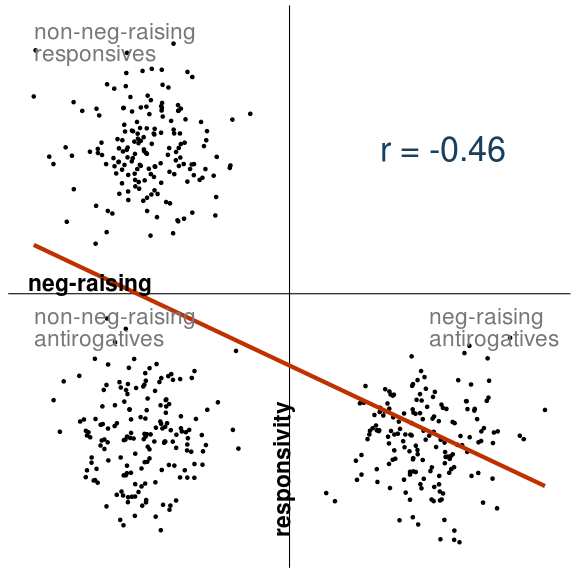

In [19]:
%%R -i theiler_lexicon -w 8 -h 8 -u in

g <- ggplot(theiler_lexicon, aes(x=negraising, y=responsivity)) + geom_point() + 
  geom_hline(yintercept=0) + geom_vline(xintercept=0) + 
  geom_smooth(se=F, method="lm", size=2, color="#BF3100") + 
  theme_classic() + 
  theme(axis.text=element_blank(), axis.title = element_blank(), axis.ticks = element_blank(), axis.line = element_blank()) + 
  annotate("text", x=min(theiler_lexicon$negraising)+.40, y=.075, label="neg-raising", size=8, fontface="bold") + 
  annotate("text", x=-.06, y=min(theiler_lexicon$responsivity)+.5, label="responsivity", size=8, fontface="bold", angle=90) + 
  annotate("text", x=min(theiler_lexicon$negraising), y=1.8, label="non-neg-raising", color="#777777", size=8, hjust=0) + 
  annotate("text", x=min(theiler_lexicon$negraising), y=1.65, label="responsives", color="#777777", size=8, hjust=0) +
  annotate("text", x=min(theiler_lexicon$negraising), y=-.15, label="non-neg-raising", color="#777777", size=8, hjust=0) + 
  annotate("text", x=min(theiler_lexicon$negraising), y=-.3, label="antirogatives", color="#777777", size=8, hjust=0) +
  annotate("text", x=1, y=-.15, label="neg-raising", color="#777777", size=8, hjust=0) + 
  annotate("text", x=1, y=-.3, label="antirogatives", color="#777777", size=8, hjust=0) + 
  annotate("text", x=.65, y=1, label=paste("r =", round(cor(theiler_lexicon$negraising, theiler_lexicon$responsivity), 2)), color="#173f5f", size=12, hjust=0)

ggsave('plots/theiler-predictions.pdf', width=8, height=8)

g

The following simulates the data shown in Figure 2 (right).

In [20]:
np.random.seed(403928)

negraising_proportions = [i/10 for i in range(1, 10, 2)]

theiler_stats = []

for r in distance_std_ratios:
    for p in negraising_proportions:
        mean_ci = np.percentile([sample_theiler_lexicon(proportion_negraising=p, 
                                                        distance_std_ratio=r)[1] 
                                 for _ in range(999)], 
                                [2.5, 50, 97.5])
        theiler_stats.append([p, r] + list(mean_ci))
        
theiler_stats = pd.DataFrame(theiler_stats, 
                          columns=['proportion_negraising', 
                                   'distance_std_ratio', 
                                   'cilo', 'med', 'cihi'])

theiler_stats

,proportion_negraising,distance_std_ratio,cilo,med,cihi
0,0.1,0.03125,-0.090215,0.000881,0.084275
1,0.3,0.03125,-0.092405,-0.002544,0.088418
2,0.5,0.03125,-0.090206,0.000670,0.089763
3,0.7,0.03125,-0.086042,-0.002157,0.091053
4,0.9,0.03125,-0.086129,-0.001443,0.082460
5,0.1,0.06250,-0.092499,0.000135,0.089460
6,0.3,0.06250,-0.087562,-0.001242,0.084221
7,0.5,0.06250,-0.090724,-0.001447,0.085469
8,0.7,0.06250,-0.091954,-0.003548,0.090276
9,0.9,0.06250,-0.090001,0.000603,0.079564


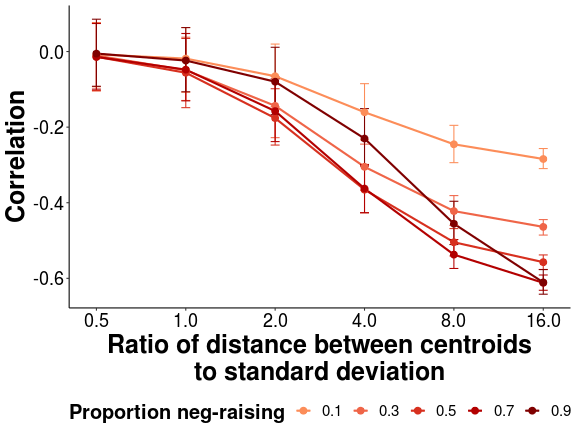

In [21]:
%%R -i theiler_stats -w 8 -h 6 -u in

library(tidyverse)

g = ggplot(filter(theiler_stats, distance_std_ratio>=0.5), 
       aes(x=distance_std_ratio, y=med, ymin=cilo, ymax=cihi, color=as.factor(proportion_negraising))) +
scale_x_continuous(trans='log2', breaks=c(0.5, 1, 2, 4, 8, 16)) +
geom_line(size=1) +
geom_errorbar(width=0.1) +
geom_point(size=3) +
scale_color_manual(name="Proportion neg-raising", values=c('#fc8d59','#ef6548','#d7301f','#b30000','#7f0000')) +
xlab("Ratio of distance between centroids\nto standard deviation") +
ylab('Correlation') +
theme_classic() +
theme(legend.position="bottom",
     axis.text=element_text(size=18, color="black"),
     axis.title=element_text(size=25, face="bold"),
     legend.text=element_text(size=15, color="black"),
     legend.title=element_text(size=20, face="bold"))

ggsave('plots/theiler-simulations.pdf', width=8, height=6)

g

We then compute a normalized neg-raising score for all of the verbs in MegaNegRaising.

In [22]:
negraising_url = 'http://megaattitude.io/projects/mega-negraising/mega-negraising-v1/mega-negraising-v1.tsv'

negraising = pd.read_csv(negraising_url, sep='\t')

negraising = negraising.query('nativeenglish')

negraising.head()

,participant,list,presentationorder,verb,frame,tense,subject,sentence1,sentence2,negraising,acceptability,nativeenglish
0,229,81,8,abhor,NP V that S,past,first,I didn't abhor that a particular thing happened.,I abhorred that that thing didn't happen.,0.30,0.97,True
1,259,81,15,abhor,NP V that S,past,first,I didn't abhor that a particular thing happened.,I abhorred that that thing didn't happen.,0.09,0.34,True
2,883,81,14,abhor,NP V that S,past,first,I didn't abhor that a particular thing happened.,I abhorred that that thing didn't happen.,0.50,0.71,True
3,665,81,22,abhor,NP V that S,past,first,I didn't abhor that a particular thing happened.,I abhorred that that thing didn't happen.,0.00,0.87,True
4,901,81,12,abhor,NP V that S,past,first,I didn't abhor that a particular thing happened.,I abhorred that that thing didn't happen.,0.33,0.61,True


In [23]:
negraising['item'] = negraising.verb + '-' + negraising.frame + '-' + negraising.subject + '-' + negraising.tense

This normalization uses the unit mixed model-based normalizer used by And & White (2020) to generate normalized neg-raising judgments.

In [24]:
def clip(var, lower=1e-20, upper=1-1e-20):
    """Clip values to lie in range [lower, upper]"""
    return tf.maximum(tf.minimum(var, upper), lower)

def fit_unit_normalizer(response: pd.Series, obj: pd.Series, participant: pd.Series,
                        learning_rate: float = 0.01, iterations: int = 50000, 
                        verbose: int = 1000, seed: int = 403923) -> Tuple[np.array, np.array, 
                                                                          np.array, np.array, 
                                                                          float, float]:
    """Fit a unit normalizer
    
    Parameters
    ----------
    response: pandas.Series[int]
        The ordinal responses
    obj: pandas.Series[int]
        The objects the ordinal responses were assigned to
    participant: pandas.Series[int]
        The participant that provided each ordinal response
    iterations: int
        The number of iterations to run the normalizer
    verbose: int
        The interval between iterations
    seed: int
        The random seed
        
    Returns
    -------
    normed_obj
        The normalized values
    likes_all
        The likelihood of the ordinal response
    scales
        The scaling term for each participant
    shifts
        The shifting term for each participant
    scale_intercept
        The fixed scaling term
    shift_intercept
        The fixed shifting term
    """
    # the total number of responses
    n = response.shape[0]
    
    # convert the input data to tf constants
    resp_tf = tf.constant(response.astype(np.float32))
    obj_tf = tf.constant(obj.astype(np.int32))
    part_tf = tf.constant(participant.astype(np.int32))
    
    # the number of responds, participants, and objects
    nresp = np.unique(response).shape[0]
    npart = np.unique(participant).shape[0]
    nobj = np.unique(obj).shape[0]
    
    # initialize the normalized values
    normed = tf.Variable(tf.random_normal([nobj], 0, 1e-5, seed=seed))
    normed_obj = tf.gather(normed, obj_tf)
    
    # initialize the fixed scaling and shifting terms
    scale_inter = tf.Variable(0.)
    shift_inter = tf.Variable(0.)
    
    # initialize the participant-specific scaling terms
    scale = tf.Variable(tf.random_normal([npart], 0, 1e-5, seed=seed+4))
    scale -= tf.reduce_mean(scale)
    scale_part = tf.gather(scale, part_tf)
    
    # initialize the participant-specific shifting terms
    shift = tf.Variable(tf.random_normal([npart], 0, 1e-5, seed=seed+6))
    shift -= tf.reduce_mean(shift)
    shift_part = tf.gather(shift, part_tf)
 
    # compute the combined positive scaling term
    scale_pos = tf.exp(scale_part+scale_inter)

    # compute the expected value in (0, 1)
    expected = tf.sigmoid(scale_pos*normed_obj+shift_part+shift_inter)
    
    # compute the random effects prior loss
    prior = 0.
    prior += tf.reduce_mean(tf.square(scale)/tf.maximum(tf.reduce_mean(tf.square(scale)), 1e-10))
    prior += tf.reduce_mean(tf.square(shift)/tf.maximum(tf.reduce_mean(tf.square(shift)), 1e-10))

    # compute the KL divergence between the expected value and the true values
    likes_all = -(clip(resp_tf)*(tf.log(clip(expected))-tf.log(clip(resp_tf)))+\
                  clip(1.-resp_tf)*(tf.log(clip(1.-expected))-tf.log(clip(1.-resp_tf))))

    like = tf.reduce_sum(likes_all)
    
    # compute the total loss
    loss = like+prior
    
    # initialize the optimizer
    optimizer = tf.train.AdamOptimizer(learning_rate)

    train_op = optimizer.minimize(loss)

    sess.run(tf.global_variables_initializer())
    
    grads_and_vars = optimizer.compute_gradients(loss)
    
    prev_best = np.inf
    
    # run the optimization
    for i in range(iterations):
        _, lk, pr, l = sess.run([train_op, like, prior, loss])
        
        prev_best = np.min([prev_best, l])
        
        if l == prev_best:
            normed_obj_out = normed_obj.eval()
            scale_out = scale.eval()
            shift_out = shift.eval()
            scale_inter_out = scale_inter.eval()
            shift_inter_out = shift_inter.eval()
            likes_all_out = likes_all.eval()
        
        if not i % verbose:
            print('iteration:', ' '*9, i)
            print('likelihood:', ' '*8, np.round(lk, 3))
            print('prior:', ' '*13, np.round(pr, 3)) 
            print('loss:', ' '*14, np.round(l, 3))
            print()
            
    return normed_obj_out, likes_all_out, scale_out, shift_out, scale_inter_out, shift_inter_out

In [25]:
negraising_response = negraising.negraising
negraising_item_codes = negraising.item.astype('category').cat.codes
negraising_participant_codes = negraising.participant.astype('category').cat.codes

with tf.Session() as sess:
    nrnorm, nrkl, scale, shift, scale_inter, shift_inter = fit_unit_normalizer(negraising_response,
                                                                               negraising_item_codes,
                                                                               negraising_participant_codes,
                                                                              iterations=2500, verbose=100)
    
negraising['negraising_normalized'], negraising['negraising_kl'] = nrnorm, nrkl

iteration:           0
likelihood:          19938.7
prior:               1.984
loss:                19940.7

iteration:           100
likelihood:          9158.2
prior:               2.0
loss:                9160.2

iteration:           200
likelihood:          8138.08
prior:               2.0
loss:                8140.08

iteration:           300
likelihood:          7801.8
prior:               2.0
loss:                7803.8

iteration:           400
likelihood:          7608.35
prior:               2.0
loss:                7610.35

iteration:           500
likelihood:          7483.47
prior:               2.0
loss:                7485.47

iteration:           600
likelihood:          7398.83
prior:               2.0
loss:                7400.83

iteration:           700
likelihood:          7335.22
prior:               2.0
loss:                7337.22

iteration:           800
likelihood:          7284.65
prior:               2.0
loss:                7286.65

iteration:           90

The normalized values themselves are real-valued. To project them back onto the unit scale, we squash them with a logistic function after scaling by the fixed scaling term then shifting by the fixed shifting term produced by the model.

In [26]:
def logistic(l):
    return 1./(1. + np.exp(-l))

negraising['negraising_normalized_logistic'] = logistic(np.exp(scale_inter)*negraising['negraising_normalized']+\
                                                        shift_inter)

We then compute the neg-raising score by taking the maximum neg-raising measure across all subject-tense combinations in the data.

In [27]:
negraising_finite = negraising[negraising.frame.isin(['NP V that S', 'NP be V that S'])]
negraising_finite_max = negraising_finite.pivot_table(index=['verb', 'frame'], 
                                                      values='negraising_normalized_logistic',
                                                      aggfunc=np.max).reset_index()

negraising_finite_max['direct_object'] = negraising_finite_max.frame == 'NP be V that S'

negraising_finite_max = negraising_finite_max.drop('frame', axis=1)

negraising_finite_max.sort_values('negraising_normalized_logistic', ascending=False)

,verb,negraising_normalized_logistic,direct_object
319,feel,0.928945,False
241,dispel,0.919803,False
559,prefer,0.919126,False
66,believe,0.916692,False
756,think,0.908623,False
739,suspect,0.880856,False
608,reckon,0.857657,False
303,experience,0.854273,False
786,venture,0.831130,False
767,trust,0.802863,False


And we merge the neg-raising measure with the responsivity measure computed earlier.

In [28]:
negraising_responsivity = pd.merge(negraising_finite_max,
                                   responsivity,
                                   on=['verb', 'direct_object'])

negraising_responsivity

,verb,negraising_normalized_logistic,direct_object,declarativity,interrogativity,responsivity
0,abhor,0.396066,False,1.130769,0.752146,0.752146
1,abhor,0.401054,True,1.159245,0.362723,0.362723
2,accept,0.481979,False,1.799351,1.564368,1.564368
3,acclaim,0.408672,False,0.814327,0.677680,0.677680
4,acknowledge,0.456079,False,3.595051,2.116735,2.116735
5,add,0.405263,False,2.903775,1.677302,1.677302
6,address,0.406081,False,1.165668,2.428402,1.165668
7,address,0.409677,True,0.836625,1.218325,0.836625
8,admire,0.430780,False,0.883934,0.625393,0.625393
9,admit,0.649063,False,2.648245,1.750189,1.750189


/opt/conda/lib/python3.5/site-packages/rpy2/rinterface/__init__.py:186: RRuntimeWarning: `geom_smooth()` using formula 'y ~ x'

  warnings.warn(x, RRuntimeWarning)


[1] "weighted r =  0.22, 95% CI = [0.14, 0.3]"


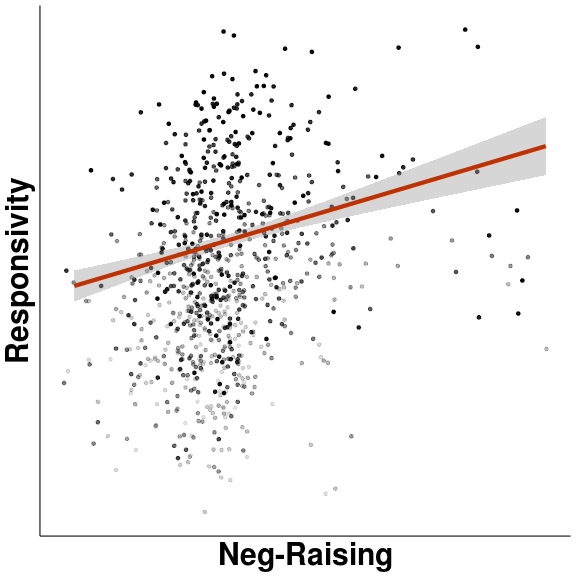

In [29]:
%%R -i negraising_responsivity -w 8 -h 8 -u in

library(boot)
library(tidyverse)

theme_set(theme_classic())

zscore = function(x) (x - mean(x))/sqrt(var(x))

negraising_responsivity$declarativity_weight = pnorm(zscore(negraising_responsivity$declarativity), 0, 1)
    
compute.weighted.correlation = function(d, i){
    d2 <- d[i,]
    weighted_corr <- cov.wt(d2[c('negraising_normalized_logistic', 'responsivity')], 
                            wt = d2$declarativity_weight, cor = TRUE)
    weighted_corr$cor['negraising_normalized_logistic', 'responsivity']
}

  
set.seed(626)
bootcorr <- boot(negraising_responsivity, compute.weighted.correlation, R=999)
r.ci = boot.ci(boot.out = bootcorr, type = c("norm"))$normal

verbs.to.label = c('know', 'figure_out', 'point_out', 'think', 'wonder', 'hope', 'fear', 'wish', 'imagine', 'dream', 
                   'tell', 'say', 'worry', 'panic', 'flip_out', 'decide', 'apologize', 'forgive', 
                   'repress', 'hush_up', 'prove', 'show', 'cry', 'notify', 'recognize',
                   'amaze', 'surprise', 'doubt', 'agree', 'lie', 'fake', 'misinform', 'pretend')

print(paste('weighted r = ', paste0(round(bootcorr$t0, 2), ','), 
            paste0('95% CI = [', round(r.ci[1,2], 2), ', ', round(r.ci[1,3], 2), ']')))
    
p <- ggplot(negraising_responsivity, aes(x=negraising_normalized_logistic, y=responsivity, alpha=declarativity_weight)) +
geom_point(position=position_jitter(0.05, 0.05)) +
xlab('Neg-Raising') + ylab('Responsivity') +
geom_smooth(method="lm", mapping = aes(weight = declarativity_weight), color="#BF3100", size=2) +
theme(axis.text=element_blank(), axis.ticks=element_blank(), 
      axis.title = element_text(size=30, face="bold"), legend.position="none") #+
# annotate(geom="text", x=0.57, y=-1.5,  size=10, color="#173f5f",
#          label=paste('weighted r = ', paste0(round(bootcorr$t0, 2), ','), 
#                      paste0('95% CI = [', 
#                             round(r.ci[1,2], 2), ', ',
#                             round(r.ci[1,3], 2), ']')))
    
ggsave('plots/negraising-responsivity.pdf', width=8, height=8)
    
p

# Grammatical correlates of polar interrogative-taking

Section 5 presents a corpus study investigating whether and how tense, aspect, and modal morphology is correlated with polar interrogative-taking. The counts, compiled using the COCA web interface, are combined in the `verb_complementizer_counts.csv` file bundled with this notebook.

In [30]:
count_data = pd.read_csv('verb_complementizer_counts.csv')

count_data = count_data[count_data.verb.isin(veridicality.verb.unique())]

count_data.sort_values('count', ascending=False)

,verb,tam,modal,transitivity,polarity,complementizer,count
11728,think,present,none,intransitive,positive,that,78206
6616,know,present,none,intransitive,positive,that,75004
10030,say,past,none,intransitive,positive,that,74959
10040,say,present,none,intransitive,positive,that,64820
1279,believe,present,none,intransitive,positive,that,51431
11194,suggest,present,none,intransitive,positive,that,41106
4820,find,past,none,intransitive,positive,that,39156
10463,show,present,none,intransitive,positive,that,32015
9993,say,infinitival,none,intransitive,positive,that,30233
6603,know,past,none,intransitive,positive,that,28897


Next, we cast the complementizer along the columns, since we will be passing the counts for each complementizer to `glm` in R using the (# successes, # failures) format.

In [31]:
count_data_binomial = count_data.pivot_table(index=['verb', 'tam', 'modal', 'transitivity', 'polarity'], 
                                             columns='complementizer', 
                                             values='count',
                                             fill_value=0).reset_index()

count_data_binomial.query('verb == "believe"').sort_values('whether', ascending=False)

complementizer,verb,tam,modal,transitivity,polarity,that,whether
518,believe,present,none,intransitive,positive,51431,6
487,believe,infinitival,none,intransitive,positive,14889,1
513,believe,past,none,transitive,negative,4,0
506,believe,modal,should,intransitive,positive,50,0
507,believe,modal,will,intransitive,negative,39,0
508,believe,modal,will,intransitive,positive,189,0
509,believe,modal,would,intransitive,negative,67,0
510,believe,modal,would,intransitive,positive,224,0
511,believe,past,none,intransitive,negative,639,0
512,believe,past,none,intransitive,positive,9478,0


We fit the logistic regression with binomial likelihood to these counts, setting the reference level for TAM (CONTEXT in the paper) to _present_ and the reference level for POLARITY to _positive_.

In [32]:
%%R -i count_data_binomial

library(lme4)

count_data_binomial$tam = as.factor(count_data_binomial$tam)
count_data_binomial$tam = relevel(count_data_binomial$tam, 'present')

count_data_binomial$polarity = as.factor(count_data_binomial$polarity)
count_data_binomial$polarity = relevel(count_data_binomial$polarity, 'positive')

summary(mm <- glmer(cbind(count_data_binomial$whether, count_data_binomial$that) ~ tam*polarity + (1|verb),
                    data=count_data_binomial, family="binomial"))

/opt/conda/lib/python3.5/site-packages/rpy2/rinterface/__init__.py:186: RRuntimeWarning: Loading required package: Matrix

  warnings.warn(x, RRuntimeWarning)
/opt/conda/lib/python3.5/site-packages/rpy2/rinterface/__init__.py:186: RRuntimeWarning: 
Attaching package: ‘Matrix’


  warnings.warn(x, RRuntimeWarning)
/opt/conda/lib/python3.5/site-packages/rpy2/rinterface/__init__.py:186: RRuntimeWarning: The following objects are masked from ‘package:tidyr’:

    expand, pack, unpack


  warnings.warn(x, RRuntimeWarning)


Generalized linear mixed model fit by maximum likelihood (Laplace
  Approximation) [glmerMod]
 Family: binomial  ( logit )
Formula: cbind(count_data_binomial$whether, count_data_binomial$that) ~  
    tam * polarity + (1 | verb)
   Data: count_data_binomial

     AIC      BIC   logLik deviance df.resid 
 27172.8  27255.4 -13573.4  27146.8     4255 

Scaled residuals: 
    Min      1Q  Median      3Q     Max 
-83.126  -0.360  -0.105  -0.018 146.902 

Random effects:
 Groups Name        Variance Std.Dev.
 verb   (Intercept) 10.82    3.289   
Number of obs: 4268, groups:  verb, 440

Fixed effects:
                                Estimate Std. Error z value Pr(>|z|)    
(Intercept)                     -6.88998    0.21122  -32.62   <2e-16 ***
taminfinitival                   2.39124    0.01895  126.19   <2e-16 ***
tammodal                         1.50449    0.02553   58.93   <2e-16 ***
tampast                         -1.51059    0.03128  -48.30   <2e-16 ***
tamperfect                      -

To test the interaction, we use `drop1` to perform a $\chi^2$ test.

In [33]:
%%R

drop1(mm, test="Chisq")

Single term deletions

Model:
cbind(count_data_binomial$whether, count_data_binomial$that) ~ 
    tam * polarity + (1 | verb)
             npar   AIC    LRT   Pr(Chi)    
<none>            27173                     
tam:polarity    5 31983 4820.5 < 2.2e-16 ***
---
Signif. codes:  0 ‘***’ 0.001 ‘**’ 0.01 ‘*’ 0.05 ‘.’ 0.1 ‘ ’ 1
